In [ ]:
!pip install note_seq
!pip install magenta

In [2]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from glob import glob

import numpy as np

from tensorflow                                  import __version__
from tensorflow.test                             import is_built_with_cuda, is_gpu_available, gpu_device_name
from tensorflow.python.client                    import device_lib

print('\nTensorflow version = {},\nbuilt with CUDA\t= {},\nGPU available\t= {},\nGPU device name = {}\n\nAll devices: {}'
      .format(__version__, is_built_with_cuda(), is_gpu_available(), gpu_device_name(), device_lib.list_local_devices()))

from tensorflow.compat.v1                        import Session
from tensorflow.python.training.checkpoint_utils import list_variables, load_variable

from keras                 import backend as K
from keras.layers          import Activation, BatchNormalization, Bidirectional, concatenate, \
                                  Conv2D, Dense, Input, LSTM, MaxPool2D, Reshape
from keras.models          import load_model, Model

from librosa               import midi_to_hz
from sklearn.metrics       import auc, roc_curve
from sklearn.preprocessing import binarize

from note_seq.sequences_lib                             import pianoroll_to_note_sequence
from magenta.models.onsets_frames_transcription.metrics import sequence_to_valued_intervals
from mir_eval.transcription                             import precision_recall_f1_overlap as Overlap
from mir_eval.transcription_velocity                    import precision_recall_f1_overlap as OverlapVolumes
from os.path               import exists, isdir
from os import makedirs
import gc


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Tensorflow version = 2.5.0,
built with CUDA	= True,
GPU available	= True,
GPU device name = /device:GPU:0

All devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13368743461890981776
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11563831473410124688
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading validation data for Maestro dataset

# dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
#     = '/content/drive/MyDrive/Maestro/maestro-v1.0.0', -87, -86, -31, -30, 40, 41

# melsVal = np.load(dataFolder + '/Mels validation.npy')
# print(len(melsVal), 'validation samples,', end='\t')
# melsValMin, melsValMean, melsValMax = melsVal.min(), melsVal.mean(), melsVal.max()
# # assert melsMinMin < melsValMin < melsMinMax and melsMeanMin < melsValMean < melsMeanMax \
# #     and melsMaxMin < melsValMax < melsMaxMax, 'Wrong mels decibels range'
# print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin, melsValMean, melsValMax))

# onVal, offVal, actVal, volsVal = map(np.load, ['{}/{} validation.npy'.format(
#     dataFolder, name) for name in ['Onsets', 'Offsets', 'Actives', 'Volumes']])
# volsValMin, volsValMean, volsValMax = volsVal.min(), volsVal.mean(), volsVal.max()
# assert volsValMin == 0 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
# print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin, volsValMean, volsValMax))

625 validation samples,	Mels decibels in range [-77 ... -30 ... 37]
Midi normalized volumes in range [0.0 ... 0.0037 ... 0.96]


In [4]:
## Loading mels validation data for Musicnet string dataset

dataFolder_string, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = '/content/drive/MyDrive/Musicnet/string', -87, -86, -31, -30, 40, 41

melsVal_string = np.load(dataFolder_string + '/Mels validation.npy')
print(len(melsVal_string), 'validation samples,', end='\t')
melsValMin_string, melsValMean_string, melsValMax_string = melsVal_string.min(), melsVal_string.mean(), melsVal_string.max()
# assert melsMinMin < melsValMin < melsMinMax and melsMeanMin < melsValMean < melsMeanMax \
#     and melsMaxMin < melsValMax < melsMaxMax, 'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin_string, melsValMean_string, melsValMax_string))

onVal_string, offVal_string, actVal_string, volsVal_string = map(np.load, ['{}/{} validation.npy'.format(
    dataFolder_string, name) for name in ['Onsets', 'Offsets', 'Actives', 'Volumes']])
volsValMin_string, volsValMean_string, volsValMax_string = volsVal_string.min(), volsVal_string.mean(), volsVal_string.max()
assert volsValMin_string == 0 and 0 < volsValMax_string <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin_string, volsValMean_string, volsValMax_string))

274 validation samples,	Mels decibels in range [-69 ... -24 ... 39]
Midi normalized volumes in range [0.0 ... 0.0036 ... 0.47]


In [5]:
## Loading mels training data for Musicnet string dataset

dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = '/content/drive/MyDrive/Musicnet/string', -87, -85, -31, -30, 38, 41

melsTrain_string, melsVal_string = map(lambda split: np.load('{}/Mels {}.npy'.format(dataFolder, split), 'r'), ['train', 'validation'])
print('{} train, {} validation samples,'.format(len(melsTrain_string), len(melsVal_string)), end='\t')

melsTrainMin,  melsValMin  = map(np.min,  [melsTrain_string, melsVal_string])
melsTrainMean, melsValMean = map(np.mean, [melsTrain_string, melsVal_string])
melsTrainMax,  melsValMax  = map(np.max,  [melsTrain_string, melsVal_string])
# assert  min(melsTrainMin,  melsValMin)  > melsMinMin  and max(melsTrainMin,  melsValMin)  < melsMinMax  \
#     and min(melsTrainMean, melsValMean) > melsMeanMin and max(melsTrainMean, melsValMean) < melsMeanMax \
#     and min(melsTrainMax,  melsValMax)  > melsMaxMin  and max(melsTrainMax,  melsValMax)  < melsMaxMax, \
#     'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
    min(melsTrainMin, melsValMin), np.mean([melsTrainMean, melsValMean]), max(melsTrainMax, melsValMax)))

2079 train, 274 validation samples,	Mels decibels in range [-77 ... -24 ... 43]


In [ ]:
## Loading onsets, offsets, volumes,actives  training data for Musicnet string dataset

onsetsTrain_string, onsetsVal_string = map(lambda split: np.load('{}/Onsets {}.npy'.format(dataFolder, split), 'r'),
                             ['train', 'validation'])
offsetsTrain_string, offsetsVal_string = map(lambda split: np.load('{}/Offsets {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])
volumesTrain_string, volumesVal_string = map(lambda split: np.load('{}/Volumes {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])

In [ ]:
activesTrain_string, activesVal_string = map(lambda split: np.load('{}/Actives {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])

Instead of training my own model, I just copy the weights from the Google's pre-trained tensorflow checkpoint:
https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip
(or look for the link here: https://github.com/tensorflow/magenta/tree/master/magenta/models/onsets_frames_transcription)

In [ ]:
#Loading checkpoint trained by Maestro piano data, you should download the checkpoint first

cptDir, lstmWidth, inputs = '/content/drive/MyDrive/Maestro/maestro-v1.0.0/checkpoint/model.ckpt', 256, Input(shape=(melsVal.shape[1], melsVal.shape[2]))

ConvBnRelu = lambda n: lambda x: Activation('relu')(BatchNormalization(scale=False)(
    Conv2D(n, 3, padding='same', use_bias=False)(x)))
outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
    ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

model = Model(inputs, Dense(88, activation='sigmoid')(Bidirectional(LSTM(lstmWidth,
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell_impl.py#L782
    # Sigmoid activation for hidden units, also unroll must be True, otherwise weights will be different
    # Cannot use stateful mode because backward LSTM would require reversed batch:
    recurrent_activation='sigmoid', implementation=2, return_sequences=True, unroll=True))(Dense(768, activation='relu')(
    Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))))

for i in [2, 3, 5, 6, 9, 10, 14, 15, 16]:
#    print(*model.layers[i].weights, sep='\n', end='\n\n')
    print()
    for weights in model.layers[i].weights:
        print(weights.name, weights.shape, sep='\t', end='\n')
print()
with Session() as sess: print(*['{}\t{}'.format(name, shape) for name, shape in list_variables(cptDir)], sep='\n')
model.summary()

In [ ]:
def MagentaToKeras(modelName, xVal, yVal):
    numLayers, varName, varProbName = 16, modelName.lower(), None
    
    for i, j in zip(range(3), [2, 5, 9]):
        model.layers[j    ].set_weights([load_variable(cptDir, '{}/conv{}/weights'     .format(varName, i))])
        model.layers[j + 1].set_weights([load_variable(cptDir, '{}/conv{}/BatchNorm/{}'.format(varName, i, name))
                                         for name in ['beta', 'moving_mean', 'moving_variance']])
    model.layers[14].set_weights([load_variable(cptDir, '{}/fc_end/{}'.format(varName, name))
                                  for name in ['weights', 'biases']])
    
    if modelName in ['Onsets', 'Offsets']: varProbName = varName[:-1] + '_probs'
    elif modelName == 'Velocity': numLayers, varProbName = 15, 'onset_velocities'
    else:
        assert modelName == 'Frame', 'Illegal model name'
        numLayers, varProbName = 20, 'frame_probs'
        model.layers[16].set_weights([load_variable(cptDir, 'frame/activation_probs/{}'.format(name))
                                      for name in ['weights', 'biases']])

    if modelName != 'Velocity':
        fW, fB, bW, bB = [load_variable(cptDir, '{}/cudnn_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/'
            '{}/cudnn_compatible_lstm_cell/{}'.format(varName, fb, kb)) for fb in ['fw', 'bw'] for kb in ['kernel', 'bias']]
        # https://stackoverflow.com/questions/48212694/in-what-order-are-weights-saved-in-a-lstm-kernel-in-tensorflow
        # Tensorflow order is I-C-F-O:
        (fWi, fWc, fWf, fWo), (bWi, bWc, bWf, bWo) = map(lambda arr: np.split(arr, 4, 1), [fW, bW])
        (fBi, fBc, fBf, fBo), (bBi, bBc, bBf, bBo) = map(lambda arr: np.split(arr, 4),    [fB, bB])
        # https://stackoverflow.com/questions/47661105/order-of-lstm-weights-in-keras
        # Keras order is I-F-C-O:
        fWk, bWk, fBk, bBk = map(np.hstack, [[fWi, fWf, fWc, fWo], [bWi, bWf, bWc, bWo],
                                             [fBi, fBf, fBc, fBo], [bBi, bBf, bBc, bBo]])
        # https://stats.stackexchange.com/questions/280995/accessing-lstm-weights-tensors-in-tensorflow
        # Input units first, then hidden (recurrent) nodes:
        model.layers[numLayers - 1].set_weights([fWk[:-lstmWidth], fWk[-lstmWidth:], fBk,
                                                 bWk[:-lstmWidth], bWk[-lstmWidth:], bBk])

    model.layers[numLayers].set_weights([load_variable(cptDir, '{}/{}/{}'.format(
        varName, varProbName, name)) for name in ['weights', 'biases']])
    model.save('Magenta {} {:.2f}.hdf5'.format(modelName, model.evaluate(
        xVal, yVal, 32, 1)[1] * 100), include_optimizer=False)

def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

# model.compile('Adam', 'categorical_crossentropy', [Dixon])
# MagentaToKeras('Onsets', melsVal, onVal)
# onProb = model.predict(melsVal, 16, 1)

# MagentaToKeras('Offsets', melsVal, offVal)
# offProb = model.predict(melsVal, 16, 1)

def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

# model = Model(model.input, Dense(volsVal.shape[2], activation='sigmoid')(model.layers[-3].output))
# model.compile('Adam', 'categorical_crossentropy', [VolAcc])
# MagentaToKeras('Velocity', melsVal, volsVal)
# volsProb = model.predict(melsVal, 32, 1)

# onsetsIn, offsetsIn = Input(shape=(onVal.shape[1], onVal.shape[2])), Input(shape=(offVal.shape[1], offVal.shape[2]))
# model = Model([onsetsIn, model.input, offsetsIn], Dense(actVal.shape[2], activation='sigmoid')(
#     Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
#                        unroll=True))(concatenate([onsetsIn, model.output, offsetsIn]))))
# model.compile('Adam', 'categorical_crossentropy', [Dixon])
# MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal)
# actProb = model.predict([onProb, melsVal, offProb], 16, 1)

In [ ]:
def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

modelFolder = '/content/drive/MyDrive/Maestro/maestro-v1.0.0/Models' # HDF5-files
if not isdir(modelFolder): makedirs(modelFolder)

def GetModel(name, accs, accTrain, accVal, xVal, yVal, evalBatchSize, withLstm, loss):
    if exists('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100)) \
            and exists('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)):
        hist = np.load('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)
                       , allow_pickle=True
                      )[0]
        print('Loading pre-trained {} model...'.format(name))
        model = load_model('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100),
                           compile=False) # Otherwise TypeError: '<' not supported between instances of 'function' and 'str'
        model.compile('Adam', loss, list(accs.values())) # But have to compile manually
        print('Spent {} epochs, current validation loss and {} are:'.format(len(hist['loss']), list(accs.keys())[0]))
        print(model.evaluate(xVal, yVal, evalBatchSize, 1))
        return model, hist

    elif not exists('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100)) \
            and not exists('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)):
        model = AcousticModel(withLstm)
        model.compile('Adam', loss, list(accs.values()))
        return model, None
    
    else: assert False, 'Either provide both training model & training history files, or none'

PlotModel = lambda: SVG(model_to_dot(model, True, show_layer_names=False, dpi=72).create(format='svg'))

In [ ]:
def TrainAndSave(xTrain, xVal, yTrain, yVal, batchSize, name, acc):
    #global hist
    
#    class ValDixon_ProgbarLogger(ProgbarLogger):
#        def __init__(self):
#            super().__init__()
#            self.verbose = 1 # ignore the argument from fit()

#        def on_train_begin(self, logs=None):
#            self.epochs = self.params['epochs']
#            self.params['metrics'].remove('val_loss')

    # if not hist: hist = model.fit(xTrain, yTrain, batchSize, validation_data=(xVal, yVal)).history
    # loss = np.inf

    # RAM으로 자꾸 터지고, epoch 조정을 위해 임시로 5 epoch으로 제한
    t = 0
    #while loss > hist['loss'][-1]:
    while t<5:
        loss, newHist = hist['loss'][-1], model.fit(xTrain, yTrain, batchSize,
#            verbose=0, callbacks=[ValDixon_ProgbarLogger()],
            validation_data=(xVal, yVal)).history
        hist = {key: hist[key] + val for key, val in newHist.items()}
        model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
            modelFolder, name, hist[acc][-1] * 100, hist['val_' + acc][-1] * 100))
        np.save('{}/Training {} History {:.2f} {:.2f}'.format(
            modelFolder, name, hist[acc][-1] * 100, hist['val_' + acc][-1] * 100), [hist])
        t = t+1

In [ ]:
def HistoryGraph(acc, title):
    plt.figure(figsize=(16, 16))

    ax1 = plt.subplot(2, 1, 1)
    plt.plot(range(1, len(hist['loss']) + 1), hist[         acc], color='#FF8000', linewidth=3, label='Training')
    plt.plot(range(1, len(hist['loss']) + 1), hist['val_' + acc], color='r', linewidth=3, label='Validation')
    plt.ylim(min(hist[acc][:-1] + hist['val_' + acc][:-1]), max(hist[acc] + hist['val_' + acc]))
    plt.title(title)
    
    ax2 = plt.subplot(2, 1, 2)
    plt.plot(range(1, len(hist['loss']) + 1), hist[    'loss'], color='g', linewidth=3, label='Training')
    plt.plot(range(1, len(hist['loss']) + 1), hist['val_loss'], color='b', linewidth=3, label='Validation')
    plt.ylim(min(hist['loss'] + hist['val_loss']), max(hist['loss'][:-1] + hist['val_loss'][:-1]))
    plt.title('Loss history')
    
    minValLoss, maxValAcc = min(hist['val_loss']), max(hist['val_' + acc])
    lossInd, accInd = hist['val_loss'].index(minValLoss), hist['val_' + acc].index(maxValAcc)
    accTrain, accVal = hist[acc][lossInd], hist['val_' + acc][lossInd]
    for a in [ax1, ax2]:
        a.vlines(lossInd + 1, 0, 12, 'b', linewidth=3,
                   label='Min validation loss, validation {} = {:.2%}'.format(acc, hist['val_' + acc][lossInd]))
        a.vlines(accInd + 1, 0, 12, 'r', linewidth=3,
                   label=                 'Max validation {} = {:.2%}'.format(acc, maxValAcc))
        a.legend()
        a.set_xlabel('Epoch')
        a.set_xlim(1, len(hist['loss']))
        a.grid()
    
    print('Maximum validation {0} = {1:.2%}, but the chosen ones are at the minimum validation loss:\n'
          'Train = {2:.2%}, Validation = {3:.2%}'.format(acc, maxValAcc, accTrain, accVal))
    return accTrain, accVal

#Transfer-Learning

In [ ]:
#checkpoint model 불러오기
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model((dataFolder_string +'/Magenta {}.hdf5').format(
    name), compile=False), ['Onsets 69.61', 'Offsets 52.52', 'Frame 81.52', 'Velocity 93.66'])

In [ ]:
offsetsModel_string = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Offsets Model 8.93 3.64.hdf5',compile=False)
onsetsModel_string = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Onsets Model 14.19 5.03.hdf5',compile=False)

In [ ]:
activesModel_string = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Actives Model 61.04 0.hdf5',compile=False)

##Fine-tuning pre-trained model by Magenta team, using musicnet string dataset

###1) Onset

In [ ]:
modelFolder2 = '/content/drive/MyDrive/Musicnet/string/Models' # Directory for HDF5-files
if not isdir(modelFolder2): makedirs(modelFolder2)

In [ ]:
#onProb for frame model of checkpoint model 

onsetsModel.compile('Adam', 'binary_crossentropy', [Dixon])
onProb = onsetsModel.predict(melsVal_string,4, 1)

9/9 [==============================] - 314s 242ms/step - loss: 0.0551 - Dixon: 0.0890


In [ ]:
#fine-training model with preprocessed musicnet data
model = onsetsModel
model.compile('Adam', 'binary_crossentropy', [Dixon])
history = model.fit(melsTrain_string, onsetsTrain_string, batch_size=4, epochs=4,validation_data=(melsVal_string, onsetsVal_string))

Epoch 1/4
520/520 [==============================] - 832s 685ms/step - loss: 0.0260 - Dixon: 0.0595 - val_loss: 0.0308 - val_Dixon: 0.0190
Epoch 2/4
520/520 [==============================] - 214s 412ms/step - loss: 0.0189 - Dixon: 0.0856 - val_loss: 0.0299 - val_Dixon: 0.0269
Epoch 3/4
520/520 [==============================] - 211s 405ms/step - loss: 0.0171 - Dixon: 0.1154 - val_loss: 0.0291 - val_Dixon: 0.0493
Epoch 4/4
520/520 [==============================] - 211s 406ms/step - loss: 0.0162 - Dixon: 0.1388 - val_loss: 0.0291 - val_Dixon: 0.0503


In [ ]:
#Save model and history

hist = {key: val for key, val in history.history.items()}
model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
    modelFolder2, 'Onsets', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100))
np.save('{}/Training {} History {:.2f} {:.2f}'.format(
    modelFolder2, 'Onsets', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100), [hist])

520/520 [==============================] - 756s 593ms/step - loss: 2.1275 - Dixon: 0.0184 - val_loss: 2.6049 - val_Dixon: 0.0169

In [ ]:
#Load saved Onset model
onsetsModel_string = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Onsets Model 14.19 5.03.hdf5',compile=False)

In [ ]:
#onProb Val for frame model, transfer learning
onProb_string = onsetsModel_string.predict(melsVal_string, 4, 1)

69/69 [==============================] - 221s 144ms/step


In [ ]:
#onProb train for frame model, transfer learning
onProbTrain_string = onsetsModel_string.predict(melsTrain_string, 4, 1)

520/520 [==============================] - 64s 123ms/step


###2) Offset

In [ ]:
#offProb for frame model of checkpoint model 
offsetsModel.compile('Adam', 'binary_crossentropy', [Dixon])
offProb = offsetsModel.predict(melsVal_string, 4, 1)

18/18 [==============================] - 134s 155ms/step


In [ ]:
#training model
model = offsetsModel
model.compile('Adam', 'binary_crossentropy', [Dixon])
history = model.fit(melsTrain_string, offsetsTrain_string, batch_size=4, epochs=4,validation_data=(melsVal_string, offsetsVal_string))

Epoch 1/4
520/520 [==============================] - 824s 667ms/step - loss: 0.0208 - Dixon: 0.0340 - val_loss: 0.0292 - val_Dixon: 0.0101
Epoch 2/4
520/520 [==============================] - 211s 406ms/step - loss: 0.0178 - Dixon: 0.0508 - val_loss: 0.0284 - val_Dixon: 0.0359
Epoch 3/4
520/520 [==============================] - 214s 412ms/step - loss: 0.0173 - Dixon: 0.0691 - val_loss: 0.0284 - val_Dixon: 0.0299
Epoch 4/4
520/520 [==============================] - 215s 413ms/step - loss: 0.0167 - Dixon: 0.0883 - val_loss: 0.0296 - val_Dixon: 0.0364


In [ ]:
hist = {key: val for key, val in history.history.items()}

In [ ]:
model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
    modelFolder2, 'Offsets', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100))
np.save('{}/Training {} History {:.2f} {:.2f}'.format(
    modelFolder2, 'Offsets', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100), [hist])

In [ ]:
#Load saved Offset model
offsetsModel_string = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Offsets Model 8.93 3.64.hdf5',compile=False)

In [ ]:
#offProb Validation for frame model, transfer learning
offProb_string = offsetsModel_string.predict(melsVal_string, 4, 1)

In [ ]:
#offProb training for frame model, transfer learning
offProbTrain_string = offsetsModel_string.predict(melsTrain_string, 4, 1)

###3) Frame

In [ ]:
# onsetsIn_string, offsetsIn_string = Input(shape=(onVal_string.shape[1], onVal_string.shape[2])), Input(shape=(offVal_string.shape[1], offVal_string.shape[2]))
# model = Model([onsetsIn_string, model.input, offsetsIn_string], Dense(actVal_string.shape[2], activation='sigmoid')(
#     Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
#                        unroll=True))(concatenate([onsetsIn_string, model.output, offsetsIn_string]))))
# model.compile('Adam', 'categorical_crossentropy', [Dixon])
# MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal_string)
# actProb = model.predict([onProb, melsVal, offProb], 16, 1)

In [ ]:
activesModel.compile('Adam', 'binary_crossentropy', [Dixon])
activesModel.evaluate([onProb_string, melsVal_string, offProb_string], actVal_string)

9/9 [==============================] - 259s 229ms/step - loss: 18.3097 - Dixon: 0.3220


[16.23215675354004, 0.3515265882015228]

9/9 [==============================] - 259s 229ms/step - loss: 18.3097 - Dixon: 0.3220
[16.23215675354004, 0.3515265882015228]

In [ ]:
#training model

model = activesModel
model.compile('Adam', 'binary_crossentropy', [Dixon])
history = model.fit([onProbTrain_string, melsTrain_string, offProbTrain_string], activesTrain_string, batch_size=2, epochs=1)
                   validation_data=([onProb_string, melsVal_string, offProb_string], activesVal_string))

1040/1040 [==============================] - 845s 341ms/step - loss: 0.0435 - Dixon: 0.5962


In [ ]:
# activesModel_string.compile('Adam', 'binary_crossentropy', [Dixon])
# activesModel_string.evaluate([onProb_string, melsVal_string, offProb_string], activesVal_string)

9/9 [==============================] - 358s 265ms/step - loss: 0.0947 - Dixon: 0.3897


[0.08218064159154892, 0.43895599246025085]

In [ ]:
hist = {key: val for key, val in history.history.items()}
model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
    modelFolder2, 'Actives', hist['Dixon'][-1] * 100), 0)          #None인데 양식상 0으로 지정
np.save('{}/Training {} History {:.2f} {:.2f}'.format(
    modelFolder2, 'Actives', hist['Dixon'][-1] * 100, 0), [hist])  #None인데 양식상 0으로 지정

###4) Volumes

In [ ]:
model = volumesModel
model.compile('Adam', 'binary_crossentropy', [Dixon])
history = model.fit(melsTrain_string, volumesTrain_string, batch_size=4, epochs=4,validation_data=(melsVal_string, volumesVal_string))

Epoch 1/4
520/520 [==============================] - 41s 40ms/step - loss: 0.0803 - Dixon: 9.5771e-04 - val_loss: 0.0186 - val_Dixon: 1.9111e-04
Epoch 2/4
520/520 [==============================] - 20s 38ms/step - loss: 0.0136 - Dixon: 8.7334e-04 - val_loss: 0.0180 - val_Dixon: 1.2718e-04
Epoch 3/4
520/520 [==============================] - 20s 38ms/step - loss: 0.0128 - Dixon: 0.0018 - val_loss: 0.0178 - val_Dixon: 7.5491e-05
Epoch 4/4
520/520 [==============================] - 20s 38ms/step - loss: 0.0123 - Dixon: 0.0016 - val_loss: 0.0174 - val_Dixon: 2.3252e-04


In [ ]:
hist = {key: val for key, val in history.history.items()}
model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
    modelFolder2, 'Volumes', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100))
np.save('{}/Training {} History {:.2f} {:.2f}'.format(
    modelFolder2, 'Volumes', hist['Dixon'][-1] * 100, hist['val_' + 'Dixon'][-1] * 100), [hist])

# Testing.

In [ ]:
fps = 16_000 / 512

#For pre-trained checkpoint model
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model((dataFolder_string +'/Magenta {}.hdf5').format(name), compile=False),
                                    ['Onsets 69.61', 'Offsets 52.52', 'Frame 81.52', 'Velocity 93.66'])

#For transfer learned model
# onsetsModel = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Onsets Model 14.19 5.03.hdf5',compile=False)
# offsetsModel = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Offsets Model 8.93 3.64.hdf5',compile=False)
# activesModel = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Actives Model 61.04 0.hdf5',compile=False)
# volumesModel = load_model('/content/drive/MyDrive/Musicnet/string/Models/Training Volumes Model 0.17 0.02.hdf5',compile=False)


ps_total, rs_total, f1s_total, offPs_total, offRs_total, offF1s_total, volsPs_total, volsRs_total, volsF1s_total = [],[],[],[],[],[],[],[],[]

result = [ps_total, rs_total, f1s_total, offPs_total, offRs_total, offF1s_total, volsPs_total, volsRs_total, volsF1s_total]
# np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
#                   np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s))


for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        '/content/drive/MyDrive/Musicnet/string/test/*{}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(' '.join(mels.split()[:-1]))
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal_string.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal_string.shape[1], melsVal_string.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    temp = [np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)]
    for item, value in zip(result,temp):
      item = item.append(value)

    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    #assert abs(numOnsetsTrue - numOnsetsPred) < .1

print('\n\naverage result\n\n')
print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
        'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
        'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
      .format(np.mean(ps_total), np.mean(rs_total), np.mean(f1s_total), np.mean(offPs_total), np.mean(offRs_total), np.mean(offF1s_total),
              np.mean(volsPs_total), np.mean(volsRs_total), np.mean(volsF1s_total)))

/content/drive/MyDrive/Musicnet/string/test/1933
	1 of 1
2/2 [==============================] - 164s 131ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 34.03%
Recall    (sensitivity) = 37.09%
F1-score                = 35.50%

Frames: 
Precision (specificity) = 14.36%
Recall    (sensitivity) = 15.65%
F1-score                = 14.98%

Volumes:
Precision (specificity) = 14.36%
Recall    (sensitivity) = 15.65%
F1-score                = 14.98%

Actual and predicted average number of onsets: 2.55 2.10
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2104
	1 of 1
2/2 [==============================] - 0s 140ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 34.45%
Recall    (sensitivity) = 50.04%
F1-score                = 40.81%

Frames: 
Precision (specificity) = 6.84%
Recall    (sensitivity) = 9.93%
F1-score                = 8.10%

Volumes:
Precision (specificity) = 6.84%
Recall    (sensitivity) = 9.93%
F1-score                = 8.10%

Actual and predicted average number of onsets: 2.16 1.70
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2105
	1 of 1
1/1 [==============================] - 0s 184ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 17.41%
Recall    (sensitivity) = 33.16%
F1-score                = 22.83%

Frames: 
Precision (specificity) = 3.34%
Recall    (sensitivity) = 6.37%
F1-score                = 4.39%

Volumes:
Precision (specificity) = 3.34%
Recall    (sensitivity) = 6.37%
F1-score                = 4.39%

Actual and predicted average number of onsets: 1.99 1.47
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2106
	1 of 1
1/1 [==============================] - 0s 178ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 31.30%
Recall    (sensitivity) = 38.96%
F1-score                = 34.71%

Frames: 
Precision (specificity) = 6.20%
Recall    (sensitivity) = 7.72%
F1-score                = 6.87%

Volumes:
Precision (specificity) = 6.20%
Recall    (sensitivity) = 7.72%
F1-score                = 6.87%

Actual and predicted average number of onsets: 2.31 1.91
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2112
	1 of 1
3/3 [==============================] - 1s 177ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 42.37%
Recall    (sensitivity) = 48.16%
F1-score                = 45.08%

Frames: 
Precision (specificity) = 12.88%
Recall    (sensitivity) = 14.64%
F1-score                = 13.71%

Volumes:
Precision (specificity) = 12.88%
Recall    (sensitivity) = 14.64%
F1-score                = 13.71%

Actual and predicted average number of onsets: 2.27 1.65
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2113
	1 of 1
2/2 [==============================] - 0s 130ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 62.58%
Recall    (sensitivity) = 62.92%
F1-score                = 62.75%

Frames: 
Precision (specificity) = 13.66%
Recall    (sensitivity) = 13.74%
F1-score                = 13.70%

Volumes:
Precision (specificity) = 13.66%
Recall    (sensitivity) = 13.74%
F1-score                = 13.70%

Actual and predicted average number of onsets: 2.40 1.75
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2114
	1 of 1
2/2 [==============================] - 0s 138ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 58.83%
Recall    (sensitivity) = 55.25%
F1-score                = 56.98%

Frames: 
Precision (specificity) = 16.60%
Recall    (sensitivity) = 15.59%
F1-score                = 16.08%

Volumes:
Precision (specificity) = 16.60%
Recall    (sensitivity) = 15.59%
F1-score                = 16.08%

Actual and predicted average number of onsets: 2.15 1.85
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2127
	1 of 1
2/2 [==============================] - 0s 166ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 20.26%
Recall    (sensitivity) = 26.76%
F1-score                = 23.06%

Frames: 
Precision (specificity) = 3.25%
Recall    (sensitivity) = 4.29%
F1-score                = 3.70%

Volumes:
Precision (specificity) = 3.25%
Recall    (sensitivity) = 4.29%
F1-score                = 3.70%

Actual and predicted average number of onsets: 3.29 1.60
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2131
	1 of 1
1/1 [==============================] - 0s 182ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 17.84%
Recall    (sensitivity) = 13.50%
F1-score                = 15.37%

Frames: 
Precision (specificity) = 7.29%
Recall    (sensitivity) = 5.52%
F1-score                = 6.28%

Volumes:
Precision (specificity) = 7.29%
Recall    (sensitivity) = 5.52%
F1-score                = 6.28%

Actual and predicted average number of onsets: 2.66 1.82
Predicts less notes than actual (specific classifier)

/content/drive/MyDrive/Musicnet/string/test/2138
	1 of 1
2/2 [==============================] - 0s 146ms/step

Onsets: 
Precision (specificity) = 13.01%
Recall    (sensitivity) = 29.58%
F1-score                = 18.07%

Frames: 
Precision (specificity) = 1.50%
Recall    (sensitivity) = 3.42%
F1-score                = 2.09%

Volumes:
Precision (specificity) = 1.50%
Recall    (sensitivity) = 3.42%
F1-score                = 2.09%

Actual and predicted average number of onsets: 2.47 1.58
Predicts less notes than actual (specific classifier)



average result



On

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


In [ ]:
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model((dataFolder_string +'/Magenta {}.hdf5').format(name), compile=False),
                                    ['Onsets 69.61', 'Offsets 52.52', 'Frame 81.52', 'Velocity 93.66'])

2/2 [==============================] - 0s 148ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimen

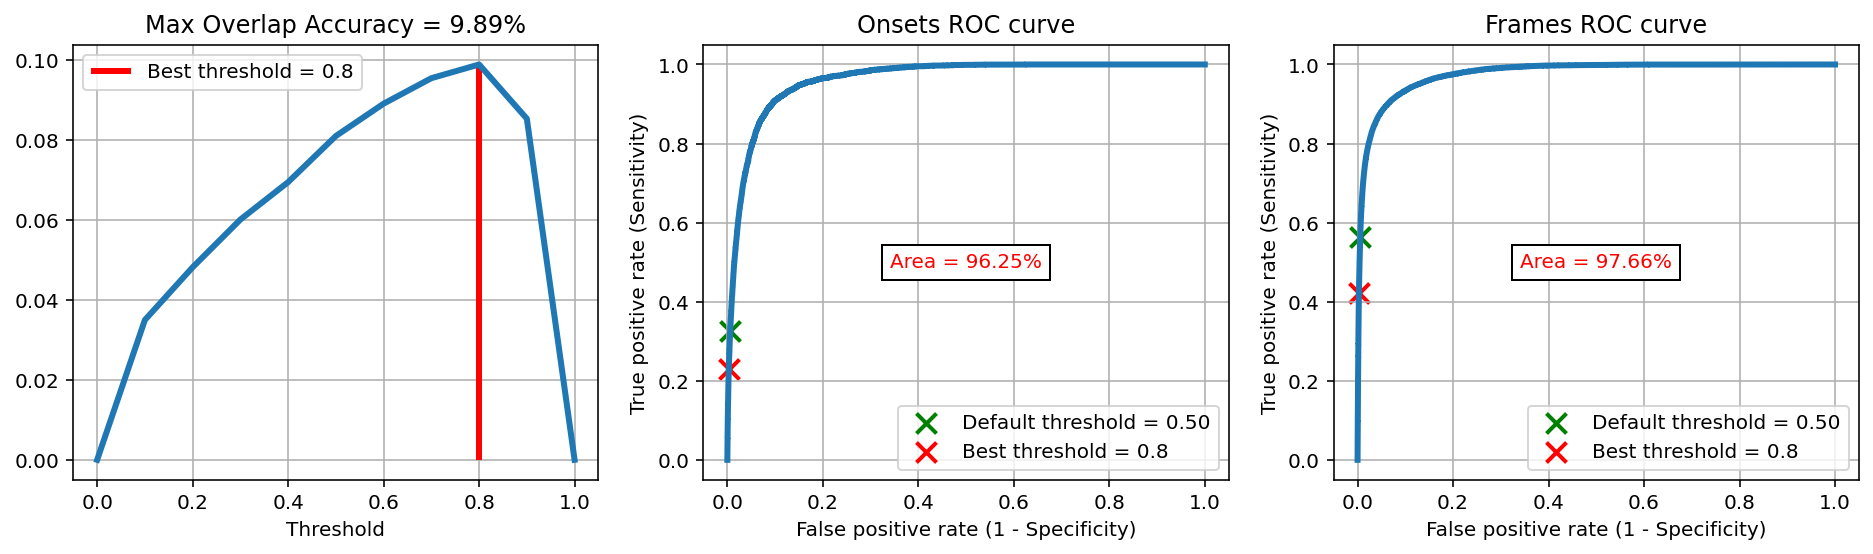

In [ ]:
fps = 16_000 / 512
mels2014, onTrue2014, offTrue2014, actTrue2014, volTrue2014 = map(lambda name: np.vstack(np.load(
#    '{}/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(dataFolder, name),
    '/content/drive/MyDrive/Musicnet/string/test/2104 {}.npy'.format(name),         #test set에서 임의로 선정
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2014 = np.pad(mels2014, [(0, -len(mels2014) % melsVal_string.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal_string.shape[1], melsVal_string.shape[2]))
onProb2014, offProb2014, volProb2014 = map(lambda mod: mod.predict(mels2014, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2014 = activesModel.predict([onProb2014, mels2014, offProb2014], 16, 1)
onProb2014, offProb2014, actProb2014, volProb2014 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2014)], [onProb2014, offProb2014, actProb2014, volProb2014])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2014, fps, 0, onset_predictions=onTrue2014, offset_predictions=offTrue2014,
            velocity_values=volTrue2014), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2014), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2014, offProb2014, actProb2014])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2014,  onProb2014, 'Onsets')
PlotROC(3, actTrue2014, actProb2014, 'Frames')

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


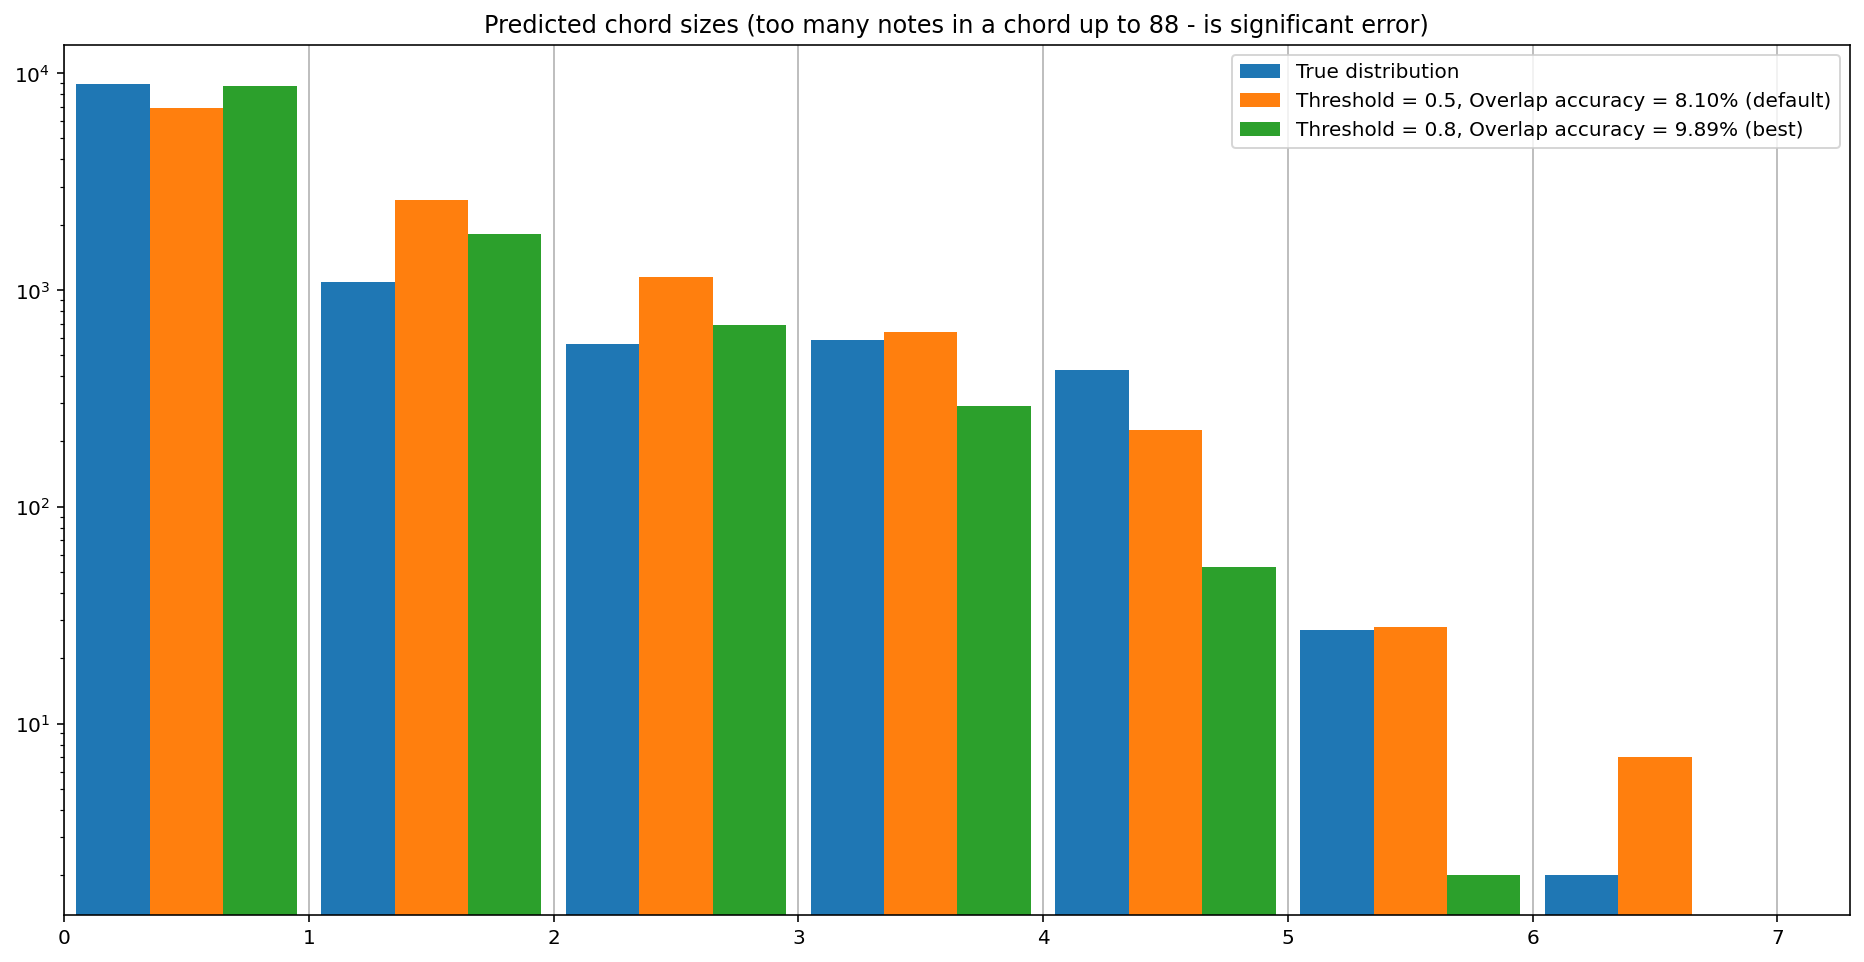

In [ ]:
yPresize, yDefault = map(lambda t: binarize(onProb2014, t).astype(int), [thBest, .5])
counts = [onTrue2014.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2014, .5),     binarize(actProb2014, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2014, thBest), binarize(actProb2014, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# Keras model HDF5-file to JSON conversion<br>(without optimizer, for using just forward-pass predictions in C++):
https://github.com/Dobiasd/frugally-deep/tree/master/keras_export

In [ ]:
%run convert_model.py   "Magenta Onsets 67.72.hdf5"  "Magenta Onsets.json"
print()
%run convert_model.py  "Magenta Offsets 44.53.hdf5" "Magenta Offsets.json"
print()
%run convert_model.py    "Magenta Frame 76.98.hdf5"  "Magenta Frames.json"
print()
%run convert_model.py "Magenta Velocity 93.40.hdf5" "Magenta Volumes.json"

loading Magenta Onsets 67.72.hdf5
Forward pass took 35.720829 s.
Forward pass took 0.508255 s.
Forward pass took 0.473182 s.
Starting performance measurements.
Forward pass took 0.515449 s.
Forward pass took 0.453743 s.
Forward pass took 0.437429 s.
Forward pass took 0.467689 s.
Forward pass took 0.480895 s.
Forward pass took 0.47104100000000004 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing Magenta Onsets.json

loading Magenta Offsets 44.53.hdf5
Forward pass took 34.224986 s.
Forward pass took 0.468311 s.
Forward pass took 0.480288 s.
Starting performance measurements.
Forward pass took 0.464745 s.
Forward pass took 0.446169 s.
Forward pass took 0.41117 s.
Forward pass took 0.443116 s.
Forward pass took 0.484776 s.
Forward pass took 0.44999520000000004 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model ha